In [1]:
from random import random, randrange
import numpy as np
import matplotlib.pyplot as plt
import json, csv
import networkx as nx

In [2]:
class trader:
    traderList = []
    id = 0
    tradetofriend = 0.7

    def __init__(self, role):
        self.id = trader.id
        trader.id += 1
        self.role = role
        if role == "honest":
            self.tradetofriend = 0.0
            self.friends = []
        elif role == "fraudleader":
            self.tradetofriend = trader.tradetofriend
            self.friends = [self]
            #for i in range(randrange(2, 4)):
            for i in range(2):
                self.friends.append(trader("fraud"))
            for friend in self.friends:
                friend.friends = self.friends
        else:
            self.tradetofriend = trader.tradetofriend
            self.friends = []
        self.owned = []
        trader.traderList.append(self)
    


    def trade(self, other, item, price):
        if item in self.owned:
            self.owned.remove(item)
            item.prevprice = price
            other.owned.append(item)
            return [self.id, other.id, item.id, price]
        else:
            print("Can't trade unowned item")
  
    def __str__(self):
        return str(self.id)

    def __repr__(self):
        return ('trader ' + str(self.id))

    def __eq__(self, other):
        return self.id == other.id

In [3]:
class item:
    nextID = 0

    def __init__(self, prevprice, owner):
        self.id = item.nextID
        self.prevprice = prevprice
        owner.owned.append(self)
        item.nextID += 1

    def __eq__(self, other):
        return self.id == other.id

    def __repr__(self):
        return str(self.id) + "-$" + str(self.prevprice)

In [4]:
class trade:
    id = 0

    def __init__(self, user1: trader, user2: trader, item: item, price, time):
        self.user1 = user1
        self.user2 = user2
        self.item = item
        self.price = price
        self.time = time
        self.id = trade.id
        trade.id += 1

    def infoDict(self):
        return {"token":self.id,"targetid": self.user2.id, "time":self.time, "value": self.price}
  
    def formatTrade(self):
        return [str(self.user1), self.infoDict()]

    def execute(self):
        self.user1.owned.remove(self.item)
        self.item.prevprice = self.price
        self.user2.owned.append(self.item)
        return self.formatTrade()

    def __repr__(self):
        return str(self.formatTrade())

In [5]:
def simulate_market(numTraders, fraudchance):
    minItems = 1
    maxItems = 3
    maxT = 100

    trader.traderList = []
    traders = trader.traderList
    trader.id = 0
    item.nextID = 0
    trade.id = 0
    for i in range(numTraders):
        if random() < fraudchance:
            newtrader = trader("fraudleader")
            newtrader.role = "fraud"
        else:
            newtrader = trader("honest")

        numItems = randrange(minItems,maxItems)
        for j in range(numItems):
            item(100, newtrader)   
    masterOut = {str(t.id) : [] for t in traders}


    tradeChance = 0.2
    for t in range(maxT):
        tradeBlock = []
        for person in traders:
            for nft in person.owned:
                if random() < tradeChance:
                    if random() < person.tradetofriend:
                        friend = person.friends[randrange(len(person.friends))]
                        while person == friend:
                            friend = person.friends[randrange(len(person.friends))]
                        tradeBlock.append(trade(person, friend, nft, nft.prevprice*(1 + 0.1*random()),t))
                    else:
                        user2 = traders[randrange(len(traders))]
                        tradeBlock.append(trade(person, user2, nft, nft.prevprice*(0.96 + 0.1*random()),t))

        for indtrade in tradeBlock:
            key, info = indtrade.execute()
            try:
                masterOut[key].append(info)
            except KeyError:
                print('Keyerror on masterOut')
                
    with open("synthetic_edges.csv","w",newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['source','target'])
        for key, value in masterOut.items():
            for singtrade in value:
                writer.writerow([key, singtrade['targetid']])
    with open("synthetic_nodes.csv","w",newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['id','role'])
        for person in traders:
            rolecolor = 1 if person.role == "fraud" else 0
            writer.writerow([person.id, rolecolor])

    traderinfo = {}
    for person in traders:
        rolecolor = 1 if person.role == "fraud" else 0
        traderinfo[str(person.id)] = [rolecolor]
    return traderinfo

In [6]:
def cluster_coeff():
    ground_truth = {}
    with open('synthetic_nodes.csv') as nodefile:
        csvreader = csv.reader(nodefile)
        header = next(csvreader)
        #print(header)
        for row in csvreader:
            ground_truth[row[0]] = int(row[1])

    edges = {}
    neighbors = {}
    coeffs = {}
    with open('synthetic_edges.csv') as edgesfile:
        csvreader = csv.reader(edgesfile)
        header = next(csvreader)
        #print(header)
        for row in csvreader:
            if row[0] == row[1]:
                continue
            if row[0] not in edges.keys():
                edges[row[0]] = []
                coeffs[row[0]] = []
                neighbors[row[0]] = []
            if row[1] not in edges.keys():
                edges[row[1]] = []
                coeffs[row[1]] = []
                neighbors[row[1]] = []
            if row[1] not in edges[row[0]]:
                edges[row[0]].append(row[1])
                neighbors[row[0]].append(row[1])
                if row[0] not in neighbors[row[1]]:
                    neighbors[row[1]].append(row[0])

    for nodei in edges.keys():
        neighboredges = 0
        k = len(neighbors[nodei])
        for nodej in neighbors[nodei]:
            for nodek in neighbors[nodei]:
                if nodek in edges[nodej]:
                    neighboredges += 1
        if k > 1:
            coeffs[nodei] = neighboredges/k/(k-1)
        else:
            coeffs[nodei] = 0
    
    #global_cluster = 0
    #total_users = 0
    #total_fraudsters =0
    #for key, coeff in coeffs.items():
    #    total_users += 1
    #    global_cluster += coeff
    #    if ground_truth[key] == 1:
    #        total_fraudsters += 1
    #global_cluster = global_cluster/total_users
    #fraudpercent = total_fraudsters/total_users
    return coeffs

In [7]:
def weighted_cluster_coeff():
    ground_truth = {}
    with open('synthetic_nodes.csv') as nodefile:
        csvreader = csv.reader(nodefile)
        header = next(csvreader)
        #print(header)
        for row in csvreader:
            ground_truth[row[0]] = int(row[1])

    edges = {}
    neighbors = {}
    weights = {}
    coeffs = {}
    with open('synthetic_edges.csv') as edgesfile:
        csvreader = csv.reader(edgesfile)
        header = next(csvreader)
        #print(header)
        for row in csvreader:
            if (row[1] == row[0]):
                continue
            if (row[0],row[1]) not in weights.keys():
                weights[(row[0],row[1])] = 1
            if (row[1],row[0]) not in weights.keys():
                weights[(row[1],row[0])] = 1
            if row[0] not in edges.keys():
                edges[row[0]] = []
                coeffs[row[0]] = []
            if row[1] not in edges.keys():
                edges[row[1]] = []
                coeffs[row[1]] = []
            if row[1] not in edges[row[0]]:
                edges[row[0]].append(row[1])
            else:
                weights[(row[0],row[1])] += 1
            if row[0] not in edges[row[1]]:
                edges[row[1]].append(row[0])
            else:
                weights[(row[1],row[0])] += 1

    for nodei in edges.keys():
        neighboredges = 0
        k = len(edges[nodei])
        s = 0
        for nodej in edges[nodei]:
            s += weights[(nodei,nodej)]
            for nodek in edges[nodei]:
                if nodek in edges[nodej] and nodek != nodei:
                    neighboredges += weights[(nodei,nodek)] + weights[(nodei,nodej)]
        if k > 1:
            coeffs[nodei] = neighboredges/2/s/(k-1)
        else:
            coeffs[nodei] = 0
            
    #global_cluster = 0
    #total_users = 0
    #total_fraudsters =0
    #for key, coeff in coeffs.items():
    #    total_users += 1
    #    global_cluster += coeff
    #    if ground_truth[key] == 1:
    #        total_fraudsters += 1
    #global_cluster = global_cluster/total_users
    #fraudpercent = total_fraudsters/total_users
    
    return coeffs

In [8]:
def pagerank():
    G = nx.MultiDiGraph()
    
    with open('synthetic_nodes.csv') as nodefile:
        csvreader = csv.reader(nodefile)
        header = next(csvreader)
        #print(header)
        for row in csvreader:
            G.add_node(row[0], role = row[1])

    with open('synthetic_edges.csv') as edgesfile:
        csvreader = csv.reader(edgesfile)
        header = next(csvreader)
        #print(header)
        for row in csvreader:
            G.add_edge(row[0], row[1])
    
    return dict(nx.degree(G)), nx.pagerank(G)

In [9]:
users = simulate_market(1000, 0.02)
cc = cluster_coeff()
wcc = weighted_cluster_coeff()
dg, pr = pagerank()
for key, value in cc.items():
    users[key].append(value)
    users[key].append(wcc[key])
    users[key].append(dg[key])
    users[key].append(pr[key])

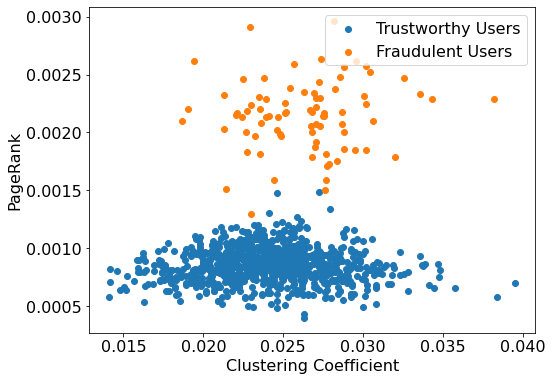

In [14]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (8,6)  # in inches
rcParams['font.size'] = 16

labels = ["Clustering Coefficient","Weighted Clustering Coefficient","Degree","PageRank"]
fraudsters = {}
honest = {}
for key, value in users.items():
    if value[0] == 1:
        fraudsters[key] = value[1::]
    else:
        honest[key] = value[1::]

ind1 = 0
ind2 = 3
plt.scatter([value[ind1] for value in honest.values()], [value[ind2] for value in honest.values()])
plt.scatter([value[ind1] for value in fraudsters.values()], [value[ind2] for value in fraudsters.values()])
plt.xlabel(labels[ind1])
plt.ylabel(labels[ind2])
plt.legend(["Trustworthy Users","Fraudulent Users"])
plt.show()